In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import os


def find_manual_peaks(series):
    peaks = []
    for i in range(1, len(series)-1):
        if series[i] > series[i-1] and series[i] > series[i+1]:
            peaks.append(i)
    return peaks

def find_manual_troughs(series):
    troughs = []
    for i in range(1, len(series)-1):
        if series[i] < series[i-1] and series[i] < series[i+1]:
            troughs.append(i)
    return troughs

# Function to calculate RSI
def calculate_rsi(df, column='Close', period=14):
    delta = df[column].diff()
    up_changes = delta.where(delta > 0, 0)
    down_changes = -delta.where(delta < 0, 0)

    if len(df) < period:
        # Not enough data toac calculate RSI
        return pd.Series([np.nan] * len(df), index=df.index)

    # Calculate initial averages of gains and losses
    initial_avg_up = up_changes.rolling(window=period).mean().dropna().iloc[0]
    initial_avg_down = down_changes.rolling(window=period).mean().dropna().iloc[0]

    # Lists to hold subsequent smoothed averages
    avg_up = [initial_avg_up]
    avg_down = [initial_avg_down]

    # Calculate subsequent averages using Wilder's smoothing method
    for i in range(period, len(up_changes)):
        avg_up.append((avg_up[-1] * (period - 1) + up_changes.iloc[i]) / period)
        avg_down.append((avg_down[-1] * (period - 1) + down_changes.iloc[i]) / period)

    avg_up_series = pd.Series(avg_up, index=df.index[period - 1:])
    avg_down_series = pd.Series(avg_down, index=df.index[period - 1:])

    # Calculate RSI
    rs = avg_up_series / avg_down_series
    rsi = 100 - (100 / (1 + rs))

    # Prepend NaNs for the initial period where RSI is not available
    rsi = pd.concat([pd.Series([np.nan] * (period - 1), index=df.index[:period - 1]), rsi])

    return rsi

In [38]:
def detect_divergences(df, tolerance=0.01):
    divergences = []

    peaks_indices = find_manual_peaks(df['Close'])
    troughs_indices = find_manual_troughs(df['Close'])

    def process_divergence(indices, find_highs):
        if len(indices) >= 2:
            for i in range(len(indices) - 1):
                # Fetch the index, price, and RSI values for the peaks/troughs
                idx1, idx2 = indices[i], indices[i+1]
                price1, price2 = df['Close'].iloc[idx1], df['Close'].iloc[idx2]
                rsi1, rsi2 = df['RSI'].iloc[idx1], df['RSI'].iloc[idx2]

                if find_highs:
                    if price1 > price2 and rsi1 > rsi2:
                        divergences.append(('Bearish', df.index[idx1], df.index[idx2], price1, price2, rsi1, rsi2))
                else:
                    if price1 < price2 and rsi1 < rsi2:
                        divergences.append(('Bullish', df.index[idx1], df.index[idx2], price1, price2, rsi1, rsi2))

    # Process both peaks and troughs
    process_divergence(peaks_indices, True)
    process_divergence(troughs_indices, False)

    return divergences

In [24]:
# Function to get historical data for a ticker
start = '2023-01-01'
end = '2024-01-01'  # This can be None if you want data up to the current date

def get_ticker_data(tickerSymbol, start, end=None, interval='1d'):
    tickerData = yf.Ticker(tickerSymbol)
    # Fetch historical data within the specified date range
    df = tickerData.history(start=start, end=end, interval=interval, auto_adjust=False)
    df['RSI'] = calculate_rsi(df)
    df['Date'] = pd.to_datetime(df.index)
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['EOM'] = df['Date'] == df.groupby(['Year', 'Month'])['Date'].transform('max')
    # No change to the data processing code that follows


#   # Define the path for the data directory
#    data_directory = "/content/data"
#    # Create the directory if it does not exist
#    if not os.path.exists(data_directory):
#        os.makedirs(data_directory)

#    # Define the full path for the CSV file within the data directory
#    raw_data_filename = os.path.join(data_directory, f'{tickerSymbol}_raw_data.csv')
#    # Save the DataFrame to CSV in the specified directory
#    df.to_csv(raw_data_filename, index=True)  # Include the datetime index in the CSV

#    print(f"Raw data for {tickerSymbol} saved to {raw_data_filename}")
    return df

def process_tickers(tickerSymbols):
    all_divergences = []
    for ticker in tickerSymbols:
        try:
            print(f"Processing {ticker}...")
            df = get_ticker_data(ticker, start, end)
            # Shift the close prices up to get the next day's close
            df['Next Bar Close'] = df['Close'].shift(-1)

            if len(df) >= 14:  # Ensure there's enough data to calculate RSI
                divergences = detect_divergences(df)

                # Append divergence details, ensuring correct alignment with the DataFrame columns
                for divergence in divergences:
                    # Find the index for the next bar close
                    idx2 = divergence[2]  # This is the index for 'Second Date'
                    next_bar_close = df.at[idx2, 'Next Bar Close'] if idx2 in df.index else np.nan

                    all_divergences.append(
                        (
                            ticker,  # Ticker
                            divergence[0],  # Type of divergence
                            divergence[1],  # First Date
                            divergence[2],  # Second Date
                            divergence[3],  # First Price
                            divergence[4],  # Second Price
                            divergence[3],  # Use First Price again as "First Close Price"
                            divergence[4],  # Use Second Price again as "Second Close Price"
                            divergence[5],  # First RSI
                            divergence[6],  # Second RSI
                            df['Close'].iloc[-1],  # Final Close Price
                            df.index[-1],  # Final Date
                            next_bar_close   # Next Bar Close
                        )
                    )
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
    return all_divergences

In [25]:
# After generating all divergences
all_divergences = process_tickers(['ISKUR.IS'])

Processing ISKUR.IS...


/tmp/ipykernel_126010/2451562783.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if series[i] > series[i-1] and series[i] > series[i+1]:
/tmp/ipykernel_126010/2451562783.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if series[i] < series[i-1] and series[i] < series[i+1]:


In [26]:
all_divergences

[('ISKUR.IS',
  'Bearish',
  Timestamp('2023-05-30 00:00:00+0300', tz='Europe/Istanbul'),
  Timestamp('2023-06-07 00:00:00+0300', tz='Europe/Istanbul'),
  767000.0,
  749000.0,
  767000.0,
  749000.0,
  49.47663993174712,
  48.45106659750121,
  8930900.0,
  Timestamp('2023-11-01 00:00:00+0300', tz='Europe/Istanbul'),
  730000.0),
 ('ISKUR.IS',
  'Bullish',
  Timestamp('2023-05-31 00:00:00+0300', tz='Europe/Istanbul'),
  Timestamp('2023-06-12 00:00:00+0300', tz='Europe/Istanbul'),
  693000.0,
  730000.0,
  693000.0,
  730000.0,
  42.68011861849815,
  46.73194731275205,
  8930900.0,
  Timestamp('2023-11-01 00:00:00+0300', tz='Europe/Istanbul'),
  770000.0),
 ('ISKUR.IS',
  'Bullish',
  Timestamp('2023-06-12 00:00:00+0300', tz='Europe/Istanbul'),
  Timestamp('2023-06-26 00:00:00+0300', tz='Europe/Istanbul'),
  730000.0,
  800000.0,
  730000.0,
  800000.0,
  46.73194731275205,
  53.494659290083725,
  8930900.0,
  Timestamp('2023-11-01 00:00:00+0300', tz='Europe/Istanbul'),
  880000.0),
 ('

In [32]:
find_manual_peaks(get_ticker_data('KCHOL.IS', start, end)['Close'])

/tmp/ipykernel_126010/2451562783.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if series[i] > series[i-1] and series[i] > series[i+1]:


[8,
 15,
 19,
 24,
 28,
 31,
 36,
 39,
 41,
 43,
 49,
 54,
 59,
 62,
 68,
 75,
 78,
 82,
 88,
 91,
 99,
 107,
 111,
 114,
 118,
 120,
 122,
 124,
 126,
 128,
 130,
 133,
 140,
 145,
 147,
 149,
 153,
 156,
 161,
 165,
 168,
 172,
 177,
 179,
 188,
 195,
 197,
 200,
 202,
 206,
 210,
 217,
 220,
 230,
 232,
 238,
 242,
 245]

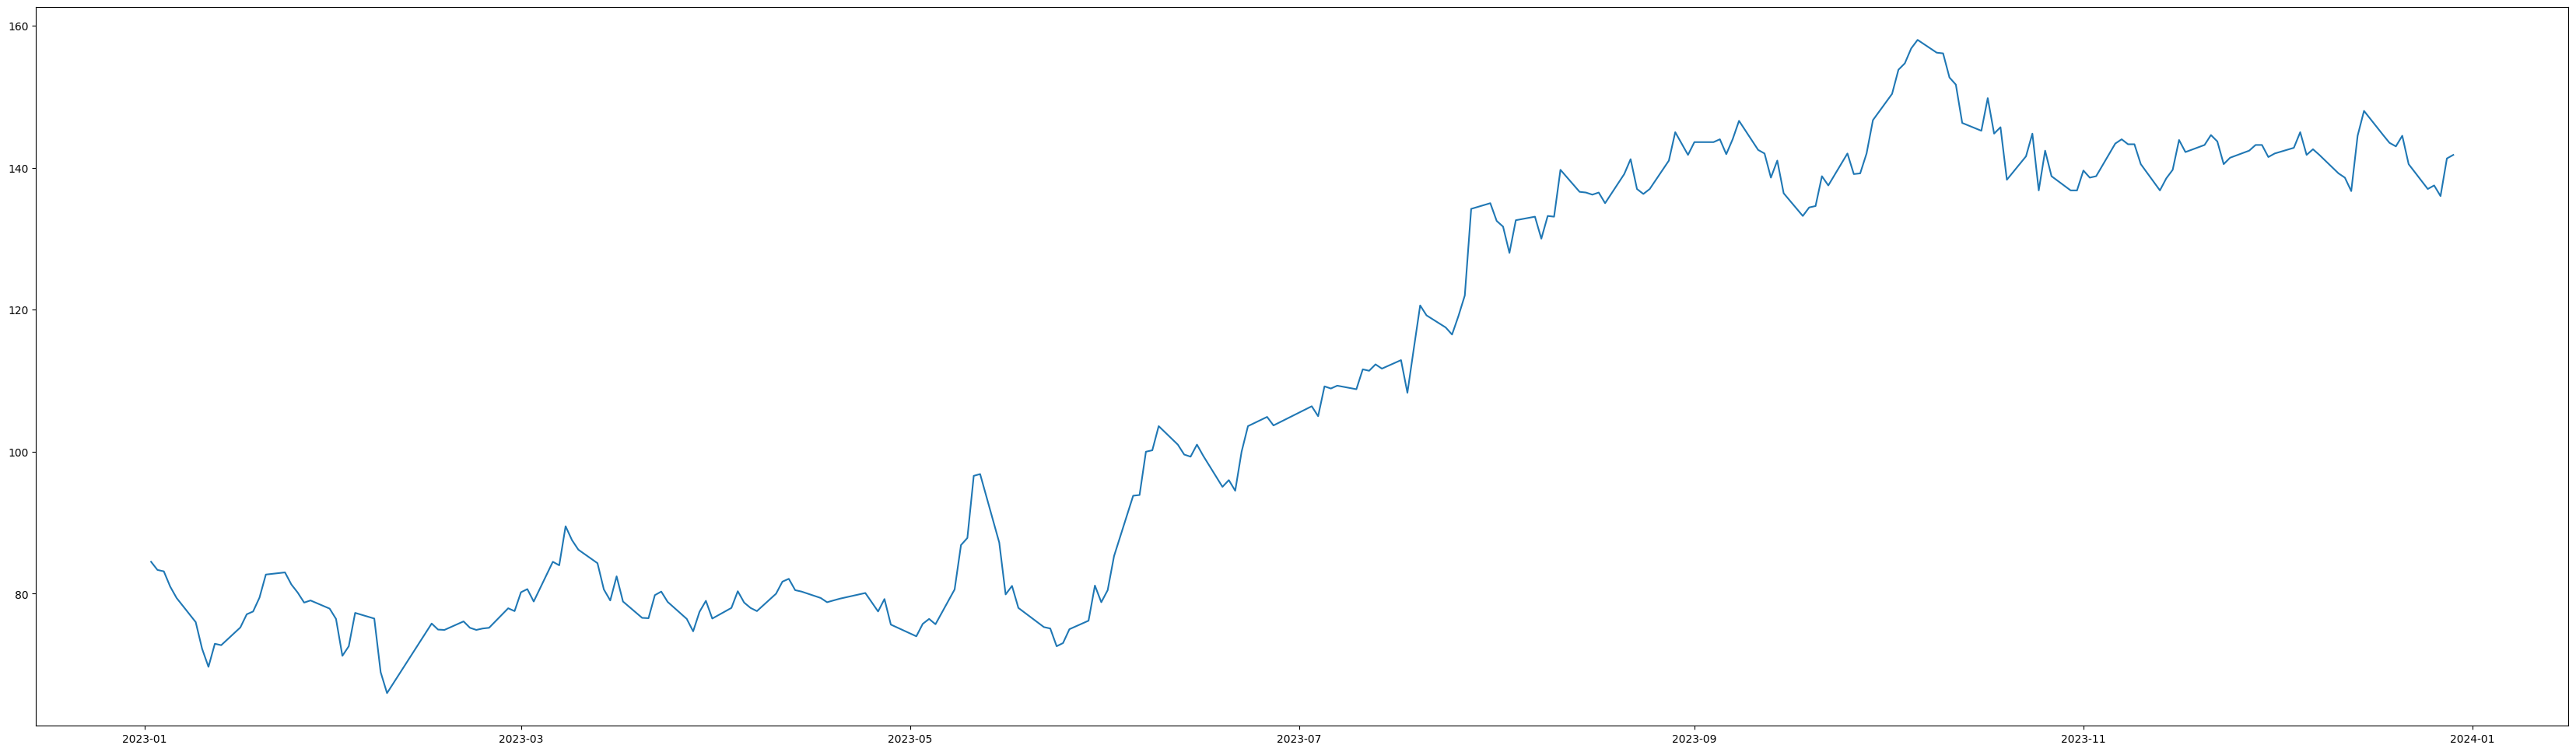

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(42,12))

plt.plot(get_ticker_data('KCHOL.IS', start, end)['Close'])

In [39]:
# After generating all divergences
all_divergences = process_tickers(['KCHOL.IS'])

# Create the DataFrame
divergences_df = pd.DataFrame(all_divergences, columns=[
    'Ticker', 'Type',
    'First Date', 'Second Date',
    'First Price', 'Second Price',
    'First Close', 'Second Close',
    'First RSI', 'Second RSI',
    'Final Close', 'Final Date',
    'Next Bar Close'  # Include the new column for Next Bar Close
])

Processing KCHOL.IS...


/tmp/ipykernel_126010/2451562783.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if series[i] > series[i-1] and series[i] > series[i+1]:
/tmp/ipykernel_126010/2451562783.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if series[i] < series[i-1] and series[i] < series[i+1]:


In [34]:
all_divergences

[('KCHOL.IS',
  'Bearish',
  Timestamp('2023-01-23 00:00:00+0300', tz='Europe/Istanbul'),
  Timestamp('2023-01-27 00:00:00+0300', tz='Europe/Istanbul'),
  83.0,
  79.05000305175781,
  83.0,
  79.05000305175781,
  47.91292197044145,
  40.80183682002079,
  141.8000030517578,
  Timestamp('2023-12-29 00:00:00+0300', tz='Europe/Istanbul'),
  77.9000015258789),
 ('KCHOL.IS',
  'Bearish',
  Timestamp('2023-03-08 00:00:00+0300', tz='Europe/Istanbul'),
  Timestamp('2023-03-16 00:00:00+0300', tz='Europe/Istanbul'),
  89.5,
  82.44999694824219,
  89.5,
  82.44999694824219,
  67.59966842779187,
  53.00268353287303,
  141.8000030517578,
  Timestamp('2023-12-29 00:00:00+0300', tz='Europe/Istanbul'),
  78.9000015258789),
 ('KCHOL.IS',
  'Bearish',
  Timestamp('2023-03-16 00:00:00+0300', tz='Europe/Istanbul'),
  Timestamp('2023-03-23 00:00:00+0300', tz='Europe/Istanbul'),
  82.44999694824219,
  80.30000305175781,
  82.44999694824219,
  80.30000305175781,
  53.00268353287303,
  50.52179842361756,
  141

In [35]:
divergences_df

,Ticker,Type,First Date,Second Date,First Price,Second Price,First Close,Second Close,First RSI,Second RSI,Final Close,Final Date,Next Bar Close
0,KCHOL.IS,Bearish,2023-01-23 00:00:00+03:00,2023-01-27 00:00:00+03:00,83.000000,79.050003,83.000000,79.050003,47.912922,40.801837,141.800003,2023-12-29 00:00:00+03:00,77.900002
1,KCHOL.IS,Bearish,2023-03-08 00:00:00+03:00,2023-03-16 00:00:00+03:00,89.500000,82.449997,89.500000,82.449997,67.599668,53.002684,141.800003,2023-12-29 00:00:00+03:00,78.900002
2,KCHOL.IS,Bearish,2023-03-16 00:00:00+03:00,2023-03-23 00:00:00+03:00,82.449997,80.300003,82.449997,80.300003,53.002684,50.521798,141.800003,2023-12-29 00:00:00+03:00,78.849998
3,KCHOL.IS,Bearish,2023-03-23 00:00:00+03:00,2023-03-30 00:00:00+03:00,80.300003,79.000000,80.300003,79.000000,50.521798,49.678220,141.800003,2023-12-29 00:00:00+03:00,76.500000
4,KCHOL.IS,Bearish,2023-04-12 00:00:00+03:00,2023-04-24 00:00:00+03:00,82.099998,80.099998,82.099998,80.099998,55.990799,51.938440,141.800003,2023-12-29 00:00:00+03:00,78.800003
5,KCHOL.IS,Bearish,2023-04-24 00:00:00+03:00,2023-04-27 00:00:00+03:00,80.099998,79.250000,80.099998,79.250000,51.938440,49.982599,141.800003,2023-12-29 00:00:00+03:00,75.650002
6,KCHOL.IS,Bearish,2023-04-27 00:00:00+03:00,2023-05-04 00:00:00+03:00,79.250000,76.449997,79.250000,76.449997,49.982599,45.187276,141.800003,2023-12-29 00:00:00+03:00,75.699997
7,KCHOL.IS,Bearish,2023-05-12 00:00:00+03:00,2023-05-17 00:00:00+03:00,96.849998,81.099998,96.849998,81.099998,75.447905,48.782495,141.800003,2023-12-29 00:00:00+03:00,78.000000
8,KCHOL.IS,Bearish,2023-06-09 00:00:00+03:00,2023-06-15 00:00:00+03:00,103.599998,101.000000,103.599998,101.000000,73.401001,67.381706,141.800003,2023-12-29 00:00:00+03:00,99.400002
9,KCHOL.IS,Bearish,2023-06-15 00:00:00+03:00,2023-06-20 00:00:00+03:00,101.000000,96.000000,101.000000,96.000000,67.381706,57.884714,141.800003,2023-12-29 00:00:00+03:00,94.500000
